# Loading the data and the packages / libraries


In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

train_v1_id = '1QzIm1OrQYhbwY7dRtdkGLK2kFOwoSfgR'

test_a_id = '17sLsGw5e2WyLWnGRqHWfbIM8fVoJPcdW'

test_b_id = '11KtpkmEZMQj-PmtfyHLlxU3Ue9UbTJmp'

test_c_id = '1_nizVEge67DbGrEv_cppl14FxU90CU1r'


downloaded_train = drive.CreateFile({'id':train_v1_id}) 
downloaded_train.GetContentFile('offenseval-training-v1.tsv') 

downloaded_test_a = drive.CreateFile({'id':test_a_id}) 
downloaded_test_a.GetContentFile('testset-taska.tsv')

downloaded_test_b = drive.CreateFile({'id':test_b_id}) 
downloaded_test_b.GetContentFile('testset-taskb.tsv') 

downloaded_test_c = drive.CreateFile({'id':test_c_id}) 
downloaded_test_c.GetContentFile('test_set_taskc.tsv') 






2020-05-13 14:30:56,686 : WARNING : file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFo

In [0]:

# Import
!pip install -U -q GPyOpt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score

from tqdm import tqdm

from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import spacy
import re
import os

import logging
from gensim.models import FastText
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras import utils
from keras.models import Model
from keras import Sequential
from keras.layers import Dropout, Conv1D, MaxPooling1D, LSTM,Concatenate, Dense, GlobalMaxPooling1D,GlobalAveragePooling1D, Lambda, Input, Bidirectional, GRU, concatenate, SpatialDropout1D, Reshape, merge
from keras.layers.embeddings import Embedding


import GPyOpt

In [0]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

--2020-05-13 14:31:07--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2020-05-13 14:31:07--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2020-05-13 14:31:08--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

# Dataset details

In [0]:
root = "drive/My Drive/OLIDv1/" 

In [0]:
# Load the unlabelled dataset

test_data_a = pd.read_csv("testset-taska.tsv", sep = "\t", header = 0)
test_data_b = pd.read_csv("testset-taskb.tsv", sep = "\t", header = 0)
test_data_c = pd.read_csv("test_set_taskc.tsv", sep = "\t", header = 0)

In [0]:
# Load the labelled dataset

data = pd.read_csv("offenseval-training-v1.tsv", sep = "\t", header = 0)

In [0]:
print("Dataset size:", len(data))

In [0]:
data.info()

In [0]:
data.head()

# Preprocessing 

## Dataset base-cleaning

In [0]:
# Load stopwords from SpaCy

nlp = spacy.load("en")
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [0]:
# Text preprocessing 
def clean_data(tweet):
    splitted_tweet = tweet.lower().split()
    clean_tweet = []
    previous_word = None
    user_count = 0
    for word in splitted_tweet:
        #if word not in spacy_stopwords:
        word = re.sub("[#@]","",word)
        word = re.sub("!"," !",word)
        word = re.sub("[?]"," ?",word)
        
        if(word == "user"):
          user_count += 1
          
        if(word == "user" and previous_word == "user"):
          pass
        else:
          clean_tweet.append(word)
          
        previous_word = word
          
    return " ".join(clean_tweet), user_count

In [0]:
#clean data and count users
data = data.merge(data.tweet.apply(lambda x:pd.Series({'clean':clean_data(x)[0], 'user_count': clean_data(x)[1]})), left_index=True, right_index=True)

In [0]:
# Normalise the user count in order to have better training performance in the neural network
max_ = data["user_count"].max()
data["user_count"] = data["user_count"].apply(lambda x:x/max_);

In [0]:
data_a = data[data["subtask_a"].notna()]
data_b = data[data["subtask_b"].notna()]
data_c = data[data["subtask_c"].notna()]

In [0]:
X_a = data_a[["clean", "user_count"]]
label_a = data_a["subtask_a"]
X_b = data_b[["clean", "user_count"]]
label_b = data_b["subtask_b"]
X_c = data_c[["clean", "user_count"]]
label_c = data_c["subtask_c"]

In [0]:
label_to_number_a = {'OFF':0,'NOT':1}
label_to_number_b = {'UNT':0,'TIN':1}
label_to_number_c = {'IND':0,'OTH':1,'GRP':2}
number_to_label_a = {v:k for k, v in label_to_number_a.items()}
number_to_label_b = {v:k for k, v in label_to_number_b.items()}
number_to_label_c = {v:k for k, v in label_to_number_c.items()}
binary_labels_a = data_a.subtask_a.apply(lambda x:label_to_number_a[x])
binary_labels_b = data_b.subtask_b.apply(lambda x:label_to_number_b[x])
binary_labels_c = data_c.subtask_c.apply(lambda x:label_to_number_c[x])

In [0]:

# Tokenisation
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.clean)
sequences = tokenizer.texts_to_sequences(data.clean)
seq = pad_sequences(sequences)

max_seq = len(seq[0])
print("maximum length of a sequence:" ,max_seq)

# Text to token
def build_seq(dataset):
  sequences = tokenizer.texts_to_sequences(dataset.clean)
  seq = pad_sequences(sequences, maxlen=max_seq)
  return seq


maximum length of a sequence: 63


In [0]:
X_train_a, X_test_a, count_train_a, count_test_a, y_train_a, y_test_a = train_test_split(build_seq(X_a), X_a.user_count, binary_labels_a, test_size=0.2)
X_train_b, X_test_b, count_train_b, count_test_b, y_train_b, y_test_b = train_test_split(build_seq(X_b), X_b.user_count, binary_labels_b, test_size=0.2)
X_train_c, X_test_c, count_train_c, count_test_c, y_train_c, y_test_c = train_test_split(build_seq(X_c), X_c.user_count, binary_labels_c, test_size=0.2)

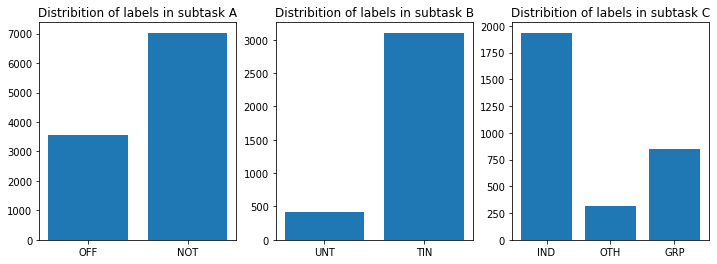

In [0]:
plt.figure(figsize = (12,4))
plt.subplot(131)
cat_a = Counter(y_train_a)
plt.bar(list(cat_a.keys()), list(cat_a.values()))
plt.xticks(range(len(cat_a)), label_to_number_a)
plt.title("Distribition of labels in subtask A");
plt.subplot(132)
cat_b = Counter(y_train_b)
plt.bar(list(cat_b.keys()), list(cat_b.values()))
plt.xticks(range(len(cat_b)), label_to_number_b)
plt.title("Distribition of labels in subtask B");
plt.subplot(133)
cat_c = Counter(y_train_c)
plt.bar(list(cat_c.keys()), list(cat_c.values()))
plt.xticks(range(len(cat_c)), label_to_number_c)
plt.title("Distribition of labels in subtask C");

## Over / under -spampling

The dataset is highly imbalanced, so we decide to combine oversampling and undersampling in order to have balanced dataset

In [0]:
def same_size_data(X_train, count_train, y_train, ratio_down_over_up=0.5):
  X_train = list(X_train)
  count_train = list(count_train)
  y_train = list(y_train)
  
  n_cat = len(Counter(y_train))
  
  sorted_counter = Counter(y_train).most_common()
  max_cat = sorted_counter[0][1]
  min_cat = sorted_counter[-1][1]
  
  target = min_cat + (1-ratio_down_over_up)*(max_cat - min_cat)
  
  for i in range(n_cat):
    diff = int(sorted_counter[i][1] - target)
    k = 0
    if diff > 0:
      rm = 0    
      while rm <= diff:
        if(y_train[k] == sorted_counter[i][0]):
          X_train.pop(k)
          y_train.pop(k)
          count_train.pop(k)
          rm += 1
          k -=1
        k += 1
    else:
      ad = 0
      while ad <= -diff:
        if(y_train[k] == sorted_counter[i][0]):
          X_train.append(X_train[k])
          y_train.append(y_train[k])
          count_train.append(count_train[k])
          ad += 1
        k += 1
        
  return X_train, count_train, y_train

In [0]:
X_train_a, count_train_a, y_train_a = same_size_data(X_train_a, count_train_a, y_train_a, 0.3)
X_train_a, count_train_a, y_train_a = shuffle(X_train_a, count_train_a, y_train_a)
X_train_b, count_train_b, y_train_b = same_size_data(X_train_b, count_train_b, y_train_b, 0.2)
X_train_b, count_train_b, y_train_b = shuffle(X_train_b, count_train_b, y_train_b)
X_train_c, count_train_c, y_train_c = same_size_data(X_train_c, count_train_c, y_train_c, 0.7)
X_train_c, count_train_c, y_train_c = shuffle(X_train_c, count_train_c, y_train_c)

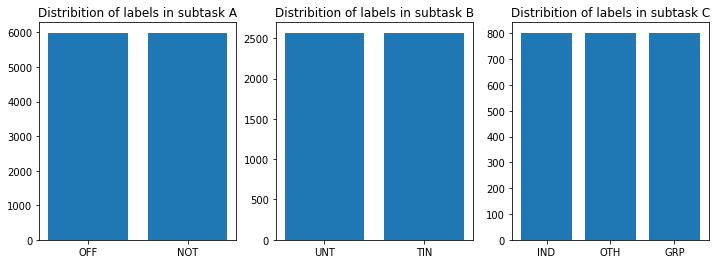

In [0]:
plt.figure(figsize = (12,4))
plt.subplot(131)
cat_a = Counter(y_train_a)
plt.bar(list(cat_a.keys()), list(cat_a.values()))
plt.xticks(range(len(cat_a)), label_to_number_a)
plt.title("Distribition of labels in subtask A");
plt.subplot(132)
cat_b = Counter(y_train_b)
plt.bar(list(cat_b.keys()), list(cat_b.values()))
plt.xticks(range(len(cat_b)), label_to_number_b)
plt.title("Distribition of labels in subtask B");
plt.subplot(133)
cat_c = Counter(y_train_c)
plt.bar(list(cat_c.keys()), list(cat_c.values()))
plt.xticks(range(len(cat_c)), label_to_number_c)
plt.title("Distribition of labels in subtask C");

# Baseline: Bag-of-Words model

In order to determine the ration of undersampling and oversampling, we use a Random Forest Classier in different ratio and perform a cross-validation.

In [0]:
def bag_of_words_class_tune_sampling(tweets_train, counts_train, label_train, tweets_test, count_test, label_test):
  tweets_train = tokenizer.sequences_to_texts(tweets_train)
  tweets_test = tokenizer.sequences_to_texts(tweets_test)
  v = CountVectorizer()
  transformed_train = v.fit_transform(tweets_train)
  transformed_test = v.transform(tweets_test)
  rf = RandomForestClassifier()
  rf.fit(scipy.sparse.hstack([transformed_train,  scipy.sparse.coo_matrix(np.array(counts_train)[:, None])]), label_train)
  
  sum = 0
  for key, elem in classification_report(rf.predict(scipy.sparse.hstack([transformed_test,  scipy.sparse.coo_matrix(np.array(count_test)[:, None])])), label_test, output_dict = True).items():
    sum += classification_report(rf.predict(scipy.sparse.hstack([transformed_test,  scipy.sparse.coo_matrix(np.array(count_test)[:, None])])), label_test, output_dict = True)[key]["f1-score"]
    
  return sum

In [0]:
a_score = 0
b_score = 0
c_score = 0

best_a_ratio = 0.1
best_b_ratio = 0.1
best_c_ratio = 0.1

for i in range(9):
  
  print("iter {}".format(i))
  temp_ratio = 0.1+i*0.1
  
  X_train_a, X_test_a, count_train_a, count_test_a, y_train_a, y_test_a = train_test_split(build_seq(X_a), X_a.user_count, binary_labels_a, test_size=0.2)
  X_train_b, X_test_b, count_train_b, count_test_b, y_train_b, y_test_b = train_test_split(build_seq(X_b), X_b.user_count, binary_labels_b, test_size=0.2)
  X_train_c, X_test_c, count_train_c, count_test_c, y_train_c, y_test_c = train_test_split(build_seq(X_c), X_c.user_count, binary_labels_c, test_size=0.2)
  
  X_train_a, count_train_a, y_train_a = same_size_data(X_train_a, count_train_a, y_train_a, temp_ratio)
  X_train_a, count_train_a, y_train_a = shuffle(X_train_a, count_train_a, y_train_a)
  X_train_b, count_train_b, y_train_b = same_size_data(X_train_b, count_train_b, y_train_b, temp_ratio)
  X_train_b, count_train_b, y_train_b = shuffle(X_train_b, count_train_b, y_train_b)
  X_train_c, count_train_c, y_train_c = same_size_data(X_train_c, count_train_c, y_train_c, temp_ratio)
  X_train_c, count_train_c, y_train_c = shuffle(X_train_c, count_train_c, y_train_c)
  
  temp_a = bag_of_words_class_tune_sampling(X_train_a, count_train_a ,y_train_a, X_test_a, count_test_a ,y_test_a)
  temp_b = bag_of_words_class_tune_sampling(X_train_b,count_train_b ,y_train_b, X_test_b,count_test_b ,y_test_b)
  temp_c = bag_of_words_class_tune_sampling(X_train_c,count_train_c ,y_train_c, X_test_c,count_test_c ,y_test_c)
  
  if(temp_a > a_score):
    best_a_ratio = temp_ratio
    a_score = temp_a
  if(temp_b > b_score):
    best_b_ratio = temp_ratio
    b_score = temp_b
  if(temp_c > c_score):
    best_c_ratio = temp_ratio
    c_score = temp_c
    
print("best_a_ratio = {}".format(best_a_ratio))
print("best_b_ratio = {}".format(best_b_ratio))
print("best_c_ratio = {}".format(best_c_ratio))

iter 0


TypeError: ignored

In [0]:
def bag_of_words_test(tweets_train, counts_train, label_train, tweets_test, count_test, label_test):
  tweets_train = tokenizer.sequences_to_texts(tweets_train)
  tweets_test = tokenizer.sequences_to_texts(tweets_test)
  v = CountVectorizer()
  transformed_train = v.fit_transform(tweets_train)
  transformed_test = v.transform(tweets_test)
  rf = RandomForestClassifier()
  rf.fit(scipy.sparse.hstack([transformed_train,  scipy.sparse.coo_matrix(np.array(counts_train)[:, None])]), label_train)
  print(classification_report(rf.predict(scipy.sparse.hstack([transformed_test,  scipy.sparse.coo_matrix(np.array(count_test)[:, None])])), label_test))

In [0]:
### Baseline results
bag_of_words_test(X_train_a, count_train_a ,y_train_a, X_test_a, count_test_a ,y_test_a)
bag_of_words_test(X_train_b,count_train_b ,y_train_b, X_test_b,count_test_b ,y_test_b)
bag_of_words_test(X_train_c,count_train_c ,y_train_c, X_test_c,count_test_c ,y_test_c)

              precision    recall  f1-score   support

           0       0.46      0.69      0.55       559
           1       0.90      0.78      0.84      2089

    accuracy                           0.76      2648
   macro avg       0.68      0.74      0.70      2648
weighted avg       0.81      0.76      0.78      2648

              precision    recall  f1-score   support

           0       0.22      0.43      0.29        46
           1       0.97      0.91      0.94       834

    accuracy                           0.89       880
   macro avg       0.59      0.67      0.61       880
weighted avg       0.93      0.89      0.91       880

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       522
           1       0.06      0.40      0.11        10
           2       0.64      0.59      0.61       244

    accuracy                           0.72       776
   macro avg       0.51      0.59      0.51       776
weighted avg       0

# Train our own embeddings

In [0]:
EMBEDDING_SIZE = 100

In [0]:
sequences = tokenizer.texts_to_sequences(data.clean)
seq = pad_sequences(sequences)
preprocessed = tokenizer.sequences_to_texts(seq)
sentences = [t.split() for t in preprocessed]

In [0]:
model = FastText(sentences, size=EMBEDDING_SIZE, window=5, min_count=1, workers=4, iter = 40)

2020-05-13 15:03:55,121 : INFO : collecting all words and their counts
2020-05-13 15:03:55,122 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-13 15:03:55,178 : INFO : PROGRESS: at sentence #10000, processed 208515 words, keeping 18006 word types
2020-05-13 15:03:55,196 : INFO : collected 21250 word types from a corpus of 276361 raw words and 13240 sentences
2020-05-13 15:03:55,197 : INFO : Loading a fresh vocabulary
2020-05-13 15:03:55,242 : INFO : effective_min_count=1 retains 21250 unique words (100% of original 21250, drops 0)
2020-05-13 15:03:55,243 : INFO : effective_min_count=1 leaves 276361 word corpus (100% of original 276361, drops 0)
2020-05-13 15:03:55,316 : INFO : deleting the raw counts dictionary of 21250 items
2020-05-13 15:03:55,317 : INFO : sample=0.001 downsamples 56 most-common words
2020-05-13 15:03:55,318 : INFO : downsampling leaves estimated 210081 word corpus (76.0% of prior 276361)
2020-05-13 15:03:55,664 : INFO : estimated r

### Embedding matrix

In [0]:
# Code if you want to use the GloVe Embedding 
embeddings_index = {}
f = open(os.path.join('glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
vocabulary_size = len(tokenizer.word_index)
vocabulary_size

21250

In [0]:
# Construct the embedding matrix for 
embedding_matrix = np.zeros((vocabulary_size+1, EMBEDDING_SIZE))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = model.wv.word_vec(word) 
        #embedding_vector = embeddings_index[word] uncomment if you want to use GloVe
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except KeyError:
        print(word)

# Convolutional Neural Network

In [0]:
# Define the layers

inp = Input(shape = (max_seq,))


y = Embedding(vocabulary_size+1, EMBEDDING_SIZE, weights = [embedding_matrix], input_length=max_seq, trainable = True)(inp)
y = Dropout(0.5)(y)
y = Conv1D(64, 4, activation='relu')(y)
y = GlobalMaxPooling1D()(y)
y = Dense(10, activation = 'relu')(y)

# The output depends on the task so we define one for a binary classification and one for prediction 3 classes
ab = Dense(1, activation = 'sigmoid')(y)
c = Dense(3, activation = 'sigmoid')(y)


Task A

In [0]:
model_conv_a = Model(inputs = inp, outputs = ab)
model_conv_a.compile(loss = "binary_crossentropy", optimizer='adam', metrics=["accuracy"] )
model_conv_a.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 63)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 63, 100)           2125100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 64)            25664     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11  

In [0]:
model_conv_a.fit(np.array(X_train_a), y_train_a, validation_data=(X_test_a,y_test_a), epochs = 10)

In [0]:
y_pred_a = model_conv_a.predict(X_test_a)
y_pred_a = y_pred_a>0.5
print(classification_report(y_test_a, y_pred_a, target_names= ["OFF",'NOT']))

              precision    recall  f1-score   support

         OFF       0.65      0.46      0.54       838
         NOT       0.78      0.89      0.83      1810

    accuracy                           0.75      2648
   macro avg       0.72      0.67      0.69      2648
weighted avg       0.74      0.75      0.74      2648



Task B

In [0]:
model_conv_b = Model(inputs = inp, outputs = ab)
model_conv_b.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"] )
model_conv_b.fit(np.array(X_train_b), y_train_b, validation_data=(X_test_b,y_test_b), epochs = 10)

In [0]:
y_pred_b = model_conv_b.predict(X_test_b)
y_pred_b = y_pred_b>0.5
print(classification_report(y_test_b, y_pred_b, target_names= ["UNT",'TIN']))

              precision    recall  f1-score   support

         UNT       0.13      0.30      0.18        92
         TIN       0.90      0.76      0.83       788

    accuracy                           0.71       880
   macro avg       0.52      0.53      0.50       880
weighted avg       0.82      0.71      0.76       880



In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix((y_test_b),(y_pred_b))
cm

array([[ 28,  64],
       [189, 599]])

In [0]:
model_conv_c = Model(inputs = inp, outputs = c)
model_conv_c.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"] )
dummy_labels_train = keras.utils.np_utils.to_categorical(y_train_c)
dummy_labels_test = keras.utils.np_utils.to_categorical(y_test_c)
model_conv_c.fit(np.array(X_train_c), dummy_labels_train, validation_data=(X_test_c,dummy_labels_test), epochs = 10, batch_size = 20)

In [0]:
y_pred_c = model_conv_c.predict(X_test_c)
y_pred_c = np.argmax(y_pred_c,axis=1)
print(classification_report(y_test_c, y_pred_c, target_names= ["IND",'OTH', "GRP"]))

              precision    recall  f1-score   support

         IND       0.68      0.86      0.76       487
         OTH       0.13      0.20      0.16        65
         GRP       0.54      0.13      0.21       224

    accuracy                           0.60       776
   macro avg       0.45      0.40      0.38       776
weighted avg       0.59      0.60      0.55       776



# Recurrent Neural Network - Bidirectional LSTM + CNN

In [0]:
inp = Input(shape = (max_seq,))

x = Embedding(vocabulary_size+1, EMBEDDING_SIZE, weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(128, return_sequences = True))(x)
x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
x = Dense(10, activation = "relu")(x)

a = Dense(1, activation = "sigmoid")(x)
c = Dense(3, activation = "softmax")(x)

model_a = Model(inputs = inp, outputs = a)
model_b = Model(inputs = inp, outputs = a)
model_c = Model(inputs = inp, outputs = c)

Task A

In [0]:
model_a.compile( loss = "binary_crossentropy", optimizer = Adam(lr=0.001), metrics = ["accuracy"])
model_a.summary()

In [0]:
model_a.fit(np.array(X_train_a), y_train_a, validation_data=(X_test_a,y_test_a), epochs = 7)

Train on 13367 samples, validate on 2648 samples
Epoch 1/7
13367/13367 [==============================] - 91s 7ms/step - loss: 0.6579 - accuracy: 0.5997 - val_loss: 0.5989 - val_accuracy: 0.6594
Epoch 2/7
13367/13367 [==============================] - 91s 7ms/step - loss: 0.5953 - accuracy: 0.6730 - val_loss: 0.5281 - val_accuracy: 0.7443
Epoch 3/7
13367/13367 [==============================] - 92s 7ms/step - loss: 0.5452 - accuracy: 0.7140 - val_loss: 0.5575 - val_accuracy: 0.6964
Epoch 4/7
13367/13367 [==============================] - 89s 7ms/step - loss: 0.5023 - accuracy: 0.7468 - val_loss: 0.5676 - val_accuracy: 0.7224
Epoch 5/7
13367/13367 [==============================] - 90s 7ms/step - loss: 0.4512 - accuracy: 0.7842 - val_loss: 0.5048 - val_accuracy: 0.7659
Epoch 6/7
13367/13367 [==============================] - 90s 7ms/step - loss: 0.4100 - accuracy: 0.8125 - val_loss: 0.5804 - val_accuracy: 0.7492
Epoch 7/7
13367/13367 [==============================] - 90s 7ms/step - los

In [0]:
y_pred_a = model_a.predict(X_test_a)
y_pred_a = y_pred_a>0.5
print(classification_report(y_test_a, y_pred_a, target_names= ["OFF",'NOT']))

              precision    recall  f1-score   support

         OFF       0.60      0.68      0.64       838
         NOT       0.84      0.79      0.82      1810

    accuracy                           0.76      2648
   macro avg       0.72      0.74      0.73      2648
weighted avg       0.77      0.76      0.76      2648



In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix((y_test_a),(y_pred_a))
cm

array([[ 573,  265],
       [ 376, 1434]])

Submission to codalab

In [0]:
test_data_a["clean data"] = test_data_a.tweet.apply(lambda x: clean_data(x)[0])
sequences = tokenizer.texts_to_sequences(test_data_a["clean data"])
seq_test_a = pad_sequences(sequences, maxlen = max_seq)

In [0]:
predictions = model_a.predict(seq_test_a)
predictions = predictions > 0.5
predictions = [number_to_label_a[int(v[0])] for v in predictions]
test_data_a["predictions"] = predictions
submit= test_data_a[["id", "predictions"]]
submit.to_csv("submission_a.csv", index = False, header = False)

Transfer Learning for task B

In [0]:
model_b.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model_b.fit(np.array(X_train_b), y_train_b, validation_data=(X_test_b,y_test_b), epochs = 3)

Train on 5645 samples, validate on 880 samples
Epoch 1/3
5645/5645 [==============================] - 45s 8ms/step - loss: 0.6812 - accuracy: 0.6106 - val_loss: 0.6791 - val_accuracy: 0.6125
Epoch 2/3
5645/5645 [==============================] - 43s 8ms/step - loss: 0.5829 - accuracy: 0.6974 - val_loss: 0.4969 - val_accuracy: 0.7705
Epoch 3/3
5645/5645 [==============================] - 43s 8ms/step - loss: 0.5075 - accuracy: 0.7543 - val_loss: 0.6579 - val_accuracy: 0.6591


In [0]:
y_pred_b = model_b.predict(X_test_b)
y_pred_b = y_pred_b > 0.5
print(classification_report(y_test_b, y_pred_b, target_names= ["UNT",'TIN']))

              precision    recall  f1-score   support

         UNT       0.17      0.57      0.26        92
         TIN       0.93      0.67      0.78       788

    accuracy                           0.66       880
   macro avg       0.55      0.62      0.52       880
weighted avg       0.85      0.66      0.72       880



In [0]:
y_pred_b = model_b.predict(X_test_b)
y_pred_b = y_pred_b > 0.5
print(classification_report(y_test_b, y_pred_b, target_names= ["UNT",'TIN']))

              precision    recall  f1-score   support

         UNT       0.17      0.57      0.26        92
         TIN       0.93      0.67      0.78       788

    accuracy                           0.66       880
   macro avg       0.55      0.62      0.52       880
weighted avg       0.85      0.66      0.72       880



In [0]:
cm = confusion_matrix((y_test_b), (y_pred_b))
cm

array([[ 28,  64],
       [189, 599]])

Submission to codalab

In [0]:
test_data_b["clean data"] = test_data_b.tweet.apply(lambda x: clean_data(x)[0])
sequences = tokenizer.texts_to_sequences(test_data_b["clean data"])
seq_test_b = pad_sequences(sequences, maxlen = max_seq)

In [0]:
predictions = model_b.predict(seq_test_b)
predictions = predictions > 0.5
predictions = [number_to_label_b[int(v[0])] for v in predictions]
test_data_b["predictions"] = predictions
submit= test_data_b[["id", "predictions"]]
submit.to_csv("submission_b.csv", index = False, header = False)

In [0]:
predictions = model_b.predict(seq_test_b)
predictions = np.argmax(predictions,axis=1)
predictions = [number_to_label_b[v] for v in predictions]
test_data_b["predictions"] = predictions
submit= test_data_b[["id", "predictions"]]
submit.to_csv("submission_b.csv", index = False, header = False)

In [0]:
from sklearn.metrics import confusion_matrix
labels_b = pd.read_csv("labels-levelb.csv", sep=",", header=None)
labels_b.columns=["id", "subtask_b"]

print(classification_report(labels_b["subtask_b"], predictions))
print(confusion_matrix(labels_b["subtask_b"], predictions))

Transfer Learning for task C

In [0]:
model_c.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
dummy_labels_train = keras.utils.np_utils.to_categorical(y_train_c)
dummy_labels_test = keras.utils.np_utils.to_categorical(y_test_c)
model_c.fit(np.array(X_train_c), dummy_labels_train, validation_data=(X_test_c,dummy_labels_test), epochs = 2)

Train on 5284 samples, validate on 776 samples
Epoch 1/2
5284/5284 [==============================] - 42s 8ms/step - loss: 1.0518 - accuracy: 0.4521 - val_loss: 0.9907 - val_accuracy: 0.5954
Epoch 2/2
5284/5284 [==============================] - 41s 8ms/step - loss: 0.9409 - accuracy: 0.5331 - val_loss: 0.9360 - val_accuracy: 0.6147


In [0]:
y_pred_c = model_c.predict(X_test_c)
y_pred_c = np.argmax(y_pred_c,axis=1)
print(classification_report(y_test_c, y_pred_c, target_names= ["IND",'OTH', "GRP"]))

              precision    recall  f1-score   support

         IND       0.85      0.62      0.72       487
         OTH       0.17      0.25      0.20        65
         GRP       0.48      0.70      0.57       224

    accuracy                           0.61       776
   macro avg       0.50      0.52      0.50       776
weighted avg       0.69      0.61      0.63       776



In [0]:
cm = confusion_matrix((y_test_c), (y_pred_c))
cm

array([[304,  46, 137],
       [ 16,  16,  33],
       [ 37,  30, 157]])

Predict on test data

In [0]:
test_data_c["clean data"] = test_data_c.tweet.apply(lambda x: clean_data(x)[0])
sequences = tokenizer.texts_to_sequences(test_data_c["clean data"])
seq_test_c = pad_sequences(sequences, maxlen = max_seq)

In [0]:
predictions = model_c.predict(seq_test_c)
predictions = np.argmax(predictions,axis=1)
predictions = [number_to_label_c[v] for v in predictions]
test_data_c["predictions"] = predictions
submit= test_data_c[["id", "predictions"]]
submit.to_csv("submission_c.csv", index = False, header = False)

In [0]:
from sklearn.metrics import confusion_matrix
labels_c = pd.read_csv("labels-levelc.csv", sep=",", header=None)
labels_c.columns=["id", "subtask_c"]

print(classification_report(labels_c["subtask_c"], predictions))
print(confusion_matrix(labels_c["subtask_c"], predictions))

Hyper-parameter tuning: Bayesian optimisation

In [0]:
def train_Bayesian_Opt(params):
  
    ## Architecture
    inp = Input(shape = (max_seq,))

    x = Embedding(vocabulary_size+1, EMBEDDING_SIZE, weights = [embedding_matrix], trainable = True)(inp)
    x = SpatialDropout1D(0.5)(x)
    x = Bidirectional(LSTM(128, return_sequences = True))(x)
    x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])
    x = Dense(10, activation = "relu")(x)

    a = Dense(1, activation = "sigmoid")(x)
    model_a = Model(inputs = inp, outputs = a)
    
    model_a.compile( loss = "binary_crossentropy", optimizer = Adam(lr = params[0,0], decay = params[0,1]), metrics = ["accuracy"])
    model_a.fit(np.array(X_train_a), y_train_a, validation_data=(X_test_a,y_test_a), epochs = 5)
    y_pred_a = model_a.predict(X_test_a)
    y_pred_a = y_pred_a>0.5
    
    
    
    
    ##Check the accuracy after every iteration of Bayesian Optimisation
    return f1_score(y_test_a, y_pred_a, average = "macro")
  

### For GPyOpt implementation details see: https://github.com/SheffieldML/GPyOpt/
domain = [{'name': 'lr',  'type': 'continuous',  'domain': (0.0005,0.01)}, {'name': 'w_decay',  'type': 'continuous',  'domain': (0, 0.000001)}]
opt = GPyOpt.methods.BayesianOptimization(f = train_Bayesian_Opt, domain = domain, acquisition_type ='LCB', acquisition_weight = 0.5)
opt.run_optimization(max_iter=10)
opt.plot_convergence()

